In [1]:
import sys
sys.path.append("../")

In [2]:
from circuits.circuits import Separable_rx, IQPLikeCircuit

from squlearn.kernel import ProjectedQuantumKernel, FidelityKernel
from qiskit.primitives import Estimator, Sampler
from squlearn.util import Executor
import numpy as np
from models.manual_kernels import variance_off_diagonal
import matplotlib.pyplot as plt

from data_tools.get_dataset import load_dataset, load_dataset_without_quantum_cache,artificial_dataset
from sklearn.svm import SVR, SVC

#import sns color palette
import seaborn as sns

#from sklearn import rbf and poly kernels
from sklearn.metrics.pairwise import rbf_kernel, polynomial_kernel

squlearn.encoding_circuit.__init__.py running


In [3]:

import seaborn as sns
import matplotlib.pyplot as plt


from matplotlib import rc
rc('text', usetex=True)


sns.set_context("paper", rc={"font.size":14,"axes.titlesize":16,"axes.labelsize":16, 
                             "legend.fontsize":14, "xtick.labelsize":16, 
                             "ytick.labelsize":16, "legend.title_fontsize":14,  'lines.linewidth': 3, 'lines.markersize': 6})


In [4]:
def eigendecomposition(K):
    """Returns ordered eigenvalues and normalized eigenvectors of a kernel matrix."""
    eigenvalue_spectrum, eigenvectors = np.linalg.eigh(1/K.shape[0] * K)
    inds_sort = np.argsort(eigenvalue_spectrum)
    inds_sort = inds_sort[::-1]
    eigenvalue_spectrum = eigenvalue_spectrum[inds_sort]
    eigenvectors = eigenvectors[:,inds_sort]
    return eigenvalue_spectrum, eigenvectors



def get_spectral_bias_tool(K_train_for_analytical, y_train_for_analytical, P_list = None, lamb = None, sigma = 0):
    """
    Calculates:
    - eigenvalue and eigenvector spectrum
    - Cumulative Power #y_train must be a column vector (num_samples, dim_of_each_y)
    - Analytical Eg

    if lamb is None or P_list is None, then it does not calculate Eg. 

    returns eigenvalue_spectrum, eigenvectors, cumul, theory_lc
    """
    #Spectra
    eigenvalue_spectrum, eigenvectors = eigendecomposition(K_train_for_analytical)    
    #Cumulative Power
    #print("y_train_for_analytical.shape", y_train_for_analytical.shape)
    #print("eigenvectors.shape", eigenvectors.shape)
    #if y is a 1d row vector, transform it to a column vector
    if len(y_train_for_analytical.shape) == 1:
        y_train_for_analytical = y_train_for_analytical.reshape(-1, 1)
        #print("y_train_for_analytical reshaped.shape", y_train_for_analytical.shape)
    power = np.sum((eigenvectors.T @ y_train_for_analytical)**2, axis = 1)
    cumul = np.cumsum(power) / np.sum(power)


    return eigenvalue_spectrum, eigenvectors, cumul, 

Loading dataset: fMNIST03
fMNIST03_8qubits_400points_0.8train_test_0seed
created fMNIST03_8qubits_400points_0.8train_test_0seed seed 0


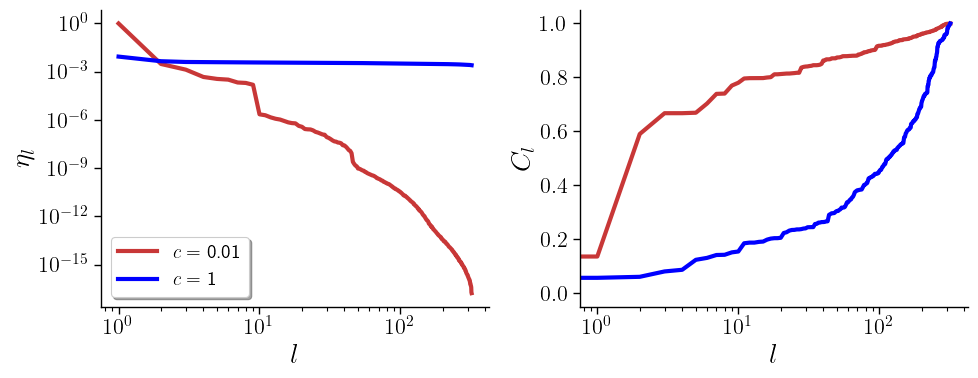

In [5]:
sns.set_context("paper", rc={"font.size":14,"axes.titlesize":16,"axes.labelsize":20, 
                             "legend.fontsize":14, "xtick.labelsize":16, 
                             "ytick.labelsize":16, "legend.title_fontsize":14,  'lines.linewidth': 3, 'lines.markersize': 6})

n_dimension = 8
n_points = 400
train_test_split_value = 0.8
seed = 0
encoding_circuit = IQPLikeCircuit(num_qubits = n_dimension, num_layers=1)
executor = Executor("pennylane")
FQK_exact = FidelityKernel(encoding_circuit, executor=executor)

x_train_pure, x_test_pure, y_train, y_test = load_dataset("fMNIST03", n_dimension, n_points, train_test_split_value, seed)
#reshape y_train to be 2D
y_train = y_train.reshape(-1,1)


c_list = [0.01,  1]

#colorblind palette
sns.set_palette("colorblind")

color_palette = sns.color_palette()
#plt ax, fig
fig, axs = plt.subplots(1,2, figsize=(10, 4))

for c_i, c in enumerate(c_list):
    KX_0andX_scan = FQK_exact.evaluate(x_train_pure*c, x_train_pure*c)
    eigenvalue_spectrum, eigenvectors, cumul = get_spectral_bias_tool(KX_0andX_scan, y_train)
    if c_i == 1:
        color_i = "#0000ffff"
    else:
        #use the hex color c83737 
        color_i = "#c83737"

    axs[0].plot(np.arange(len(eigenvalue_spectrum)) + 1, eigenvalue_spectrum, label = f"$c =$ {c}", color = color_i)
    axs[1].plot(cumul, label = f"$c =$ {c}", color = color_i)
    
    axs[0].set_yscale("log")
    axs[0].set_xscale("log")

    #axs[1].set_yscale("log")
    axs[1].set_xscale("log")

    axs[0].set_xlabel("$l$")
    axs[0].set_ylabel("$\eta_l$")

    axs[1].set_xlabel("$l$")
    axs[1].set_ylabel("$C_l$")

    #set 
    #remove xticks
    #axs[0].set_xticks([])
    #axs[1].set_xticks([])

    #axs[0].set_yticks([])
    #axs[1].set_yticks([])

    #remove top line and right line
    axs[0].spines['top'].set_visible(False)
    axs[0].spines['right'].set_visible(False)

    axs[1].spines['top'].set_visible(False)
    axs[1].spines['right'].set_visible(False)

#legend with fancy box
axs[0].legend(loc='best', fancybox=True, shadow=True, ncol=1)

plt.tight_layout()
#save figure
#plt.savefig("good_and_bad_aligmnent.svg", format="svg")